In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

In [ ]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [ ]:
print(f"Dataset_size:{dataset_size}, num_classes: {n_classes}, class_names: {class_names}")

Dataset_size:3670, num_classes: 5, class_names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [ ]:
#Again doing the same thing just while loading the data splitting it in train, test, and valid set.
test_raw, valid_raw, train_raw = tfds.load("tf_flowers", split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True)

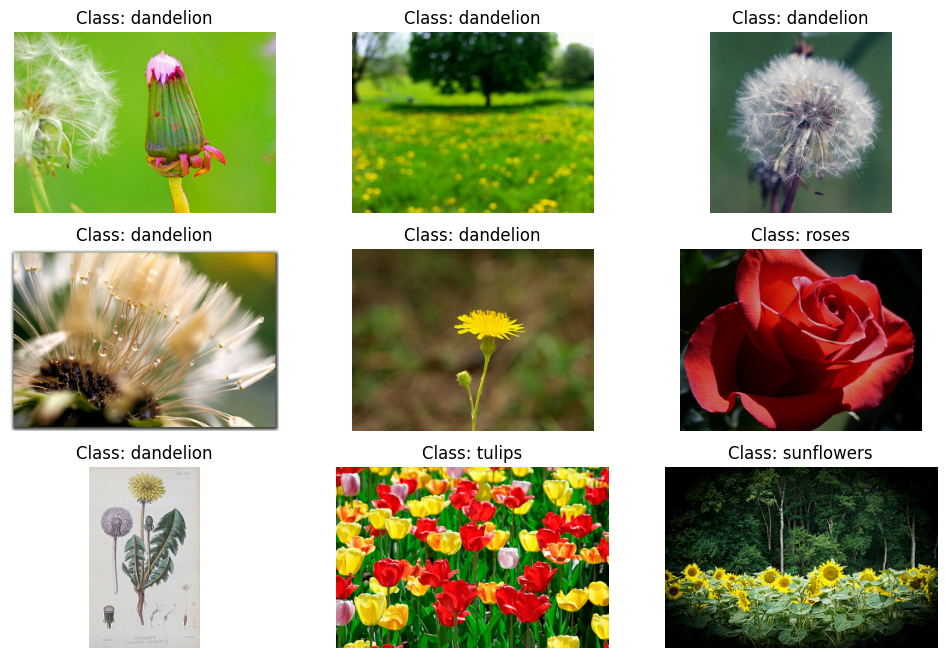

In [ ]:
plt.figure(figsize=(12,8))
index = 0
for image, label in valid_raw.take(9):
  index += 1
  plt.subplot(3,3, index)
  plt.imshow(image)
  plt.title(f"Class: {class_names[label]}")
  plt.axis("off")

plt.show()

In [ ]:
#Batch size initialization.
batch_size=32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_set = train_raw.map(lambda X,y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_raw.map(lambda X,y: (preprocess(X), y)).batch(batch_size)
test_set = test_raw.map(lambda X,y: (preprocess(X),y)).batch(batch_size)

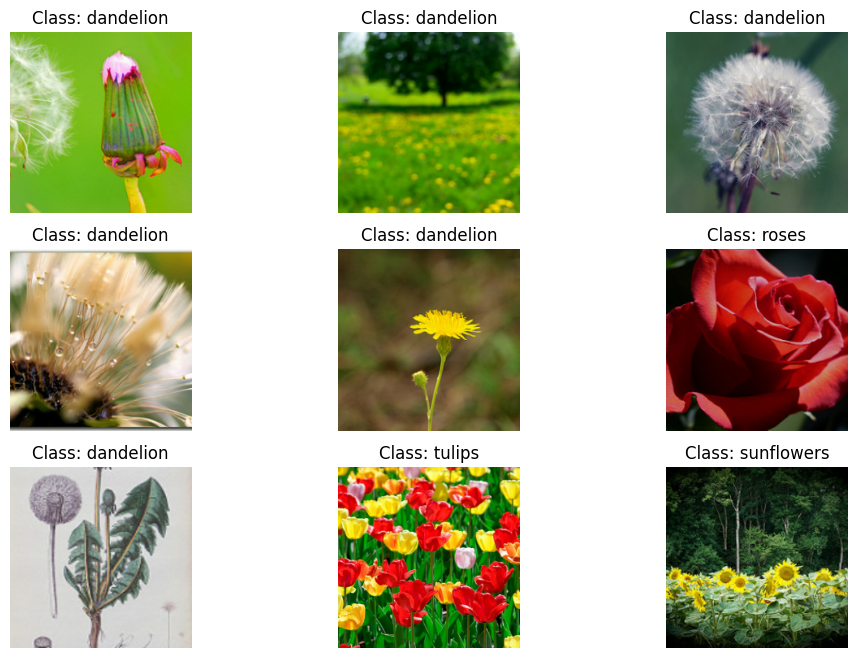

In [ ]:
plt.figure(figsize=(12,8))
for x_batch, y_batch in valid_set.take(1):
  for index in range(9):
    plt.subplot(3,3,index+1)
    plt.imshow((x_batch[index] + 1)/2)   #how does this rescaling worked?
    plt.title(f"Class: {class_names[y_batch[index]]}")
    plt.axis("off")

plt.show()

In [ ]:
data_augumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

In [ ]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs = base_model.input, outputs=output)

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
#freexing the layers
for layer in base_model.layers:
  layer.trainable = False


In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
#Warming up the model
r = model.fit(train_set, validation_data = valid_set, epochs=4)

Epoch 1/4
86/86 [==============================] - 28s 166ms/step - loss: 0.7234 - accuracy: 0.8121 - val_loss: 0.6786 - val_accuracy: 0.8421
Epoch 2/4
86/86 [==============================] - 14s 152ms/step - loss: 0.3145 - accuracy: 0.9113 - val_loss: 0.5496 - val_accuracy: 0.8784
Epoch 3/4
86/86 [==============================] - 15s 155ms/step - loss: 0.2083 - accuracy: 0.9335 - val_loss: 0.5469 - val_accuracy: 0.8639
Epoch 4/4
86/86 [==============================] - 14s 150ms/step - loss: 0.1060 - accuracy: 0.9626 - val_loss: 0.5926 - val_accuracy: 0.8512


In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
r = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 38s 297ms/step - loss: 0.2910 - accuracy: 0.9026 - val_loss: 0.5738 - val_accuracy: 0.8784
Epoch 2/10
86/86 [==============================] - 26s 296ms/step - loss: 0.0527 - accuracy: 0.9847 - val_loss: 0.3752 - val_accuracy: 0.9020
Epoch 3/10
86/86 [==============================] - 27s 306ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.3354 - val_accuracy: 0.9002
Epoch 4/10
86/86 [==============================] - 27s 300ms/step - loss: 0.0175 - accuracy: 0.9945 - val_loss: 0.3380 - val_accuracy: 0.9165
Epoch 5/10
86/86 [==============================] - 28s 311ms/step - loss: 0.0059 - accuracy: 0.9978 - val_loss: 0.3166 - val_accuracy: 0.9056
Epoch 6/10
86/86 [==============================] - 28s 315ms/step - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.3465 - val_accuracy: 0.9056
Epoch 7/10
86/86 [==============================] - 28s 314ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.3672 - val_accuracy: 0.9093

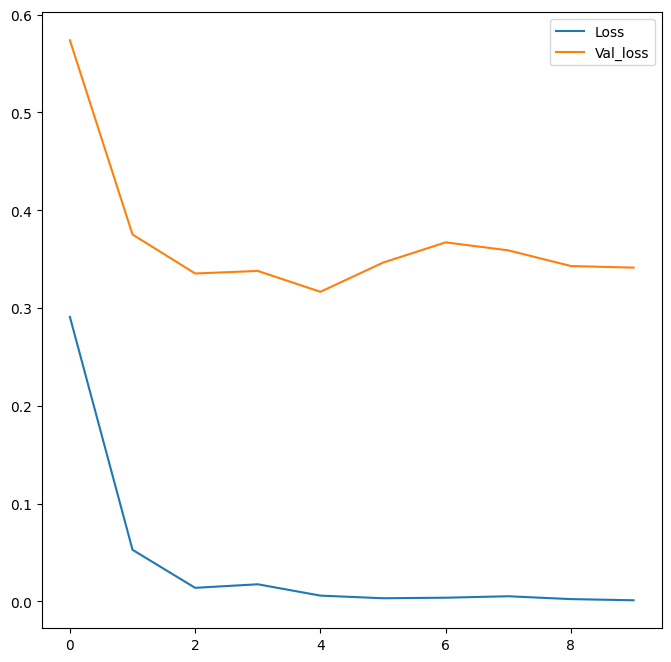

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(r.history["loss"], label="Loss")
plt.plot(r.history["val_loss"], label="Val_loss")
plt.legend(loc="upper right")
plt.show()

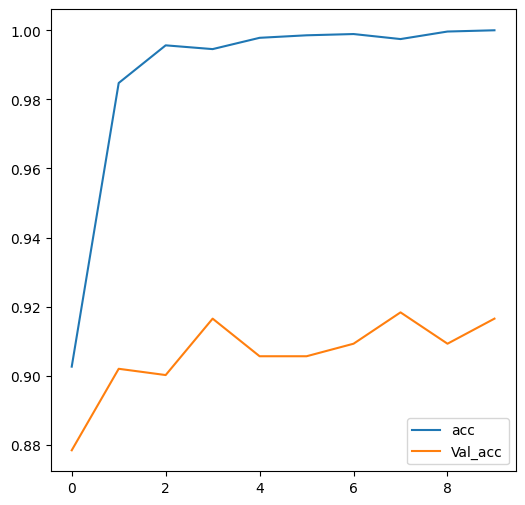

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(r.history["accuracy"], label="acc")
plt.plot(r.history["val_accuracy"], label="Val_acc")
plt.legend(loc="lower right")
plt.show()

# Testing

In [ ]:
y_pred = model.predict(test_set)

12/12 [==============================] - 4s 204ms/step


In [ ]:
y_predicted = []
for i in range(len(y_pred)):
  y_predicted.append(np.argmax(y_pred[i]))

In [ ]:
cm = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(15,8))
sns.heatmap(cm, cmap="Blues", annot=True)
plt.show()